In [190]:
import pandas as pd

df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [191]:
df.shape

(100000, 9)

In [116]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [117]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [118]:
import numpy as np

np.unique(df["smoking_history"])

array(['No Info', 'current', 'ever', 'former', 'never', 'not current'],
      dtype=object)

Nie ma braku w danych, ale jest "No info" w smoking_history, które zamienię na NaN.

In [119]:
df = df.replace("No Info", np.nan)
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,NaN,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [120]:
# Dodaje missing data do BMI, HbA1c_level oraz blood_glucose_level
df.loc[0:10,'bmi'] = np.nan
df.loc[15:25,'HbA1c_level'] = np.nan
df.loc[105:115,'blood_glucose_level'] = np.nan

In [121]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,NaN,6.6,140.0,0
1,Female,54.0,0,0,NaN,NaN,6.6,80.0,0
2,Male,28.0,0,0,never,NaN,5.7,158.0,0
3,Female,36.0,0,0,current,NaN,5.0,155.0,0
4,Male,76.0,1,1,current,NaN,4.8,155.0,0


In [122]:
df.isnull().sum()

gender                     0
age                        0
hypertension               0
heart_disease              0
smoking_history        35816
bmi                       11
HbA1c_level               11
blood_glucose_level       11
diabetes                   0
dtype: int64

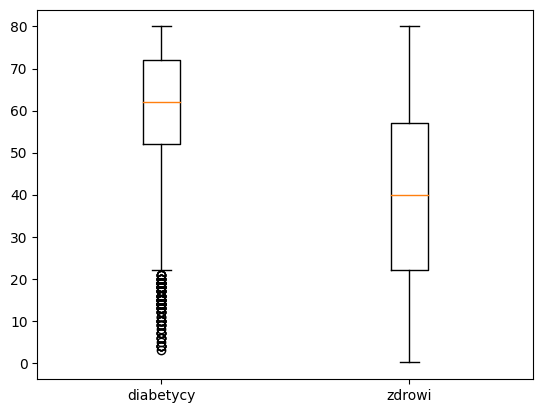

In [209]:
diabetes_true = df[df['diabetes'] == 1]
diabetes_false = df[df['diabetes'] == 0]

data = [diabetes_true['age'], diabetes_false['age']]

plt.boxplot(data, labels=['diabetycy', 'zdrowi'])
plt.show()

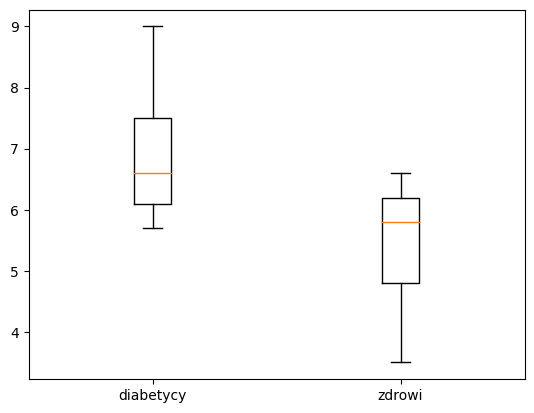

In [210]:
data = [diabetes_true['HbA1c_level'], diabetes_false['HbA1c_level']]

plt.boxplot(data, labels=['diabetycy', 'zdrowi'])
plt.show()

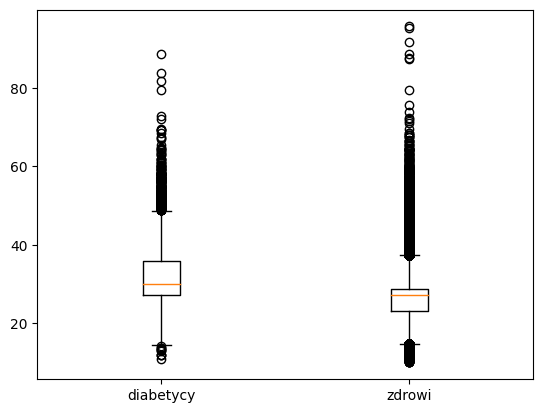

In [212]:
data = [diabetes_true['bmi'], diabetes_false['bmi']]

plt.boxplot(data, labels=['diabetycy', 'zdrowi'])
plt.show()

Dzielę na X i y oraz tworzę dane treningowe i testowe. Definiuję od razu kfold, który będę stosować przy treningu modeli.

In [123]:
X = df.loc[:, df.columns != "diabetes"]
y = df.loc[:, "diabetes"]

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import train_test_split

seed=123
kfold = model_selection.KFold(n_splits=5)
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=0.20)

Robię preprocessing pipeline.

1. Tworzę klasę **DataFrameSelector**, aby móc wybierać kolumny na podstawie ich typu.

In [125]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

2. Pipeline dla danych numerycznych:

In [126]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["age", "HbA1c_level", "blood_glucose_level"])),
        ("imputer", SimpleImputer(strategy="median")),
    ])

3. Imputer oraz pipeline dla danych kategorycznych:

In [127]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

Kategoryczne dane będą przedstawione przy pomocy OneHotEncoder.

In [128]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["gender", "hypertension", "heart_disease", "smoking_history"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])

4. Łączę w jeden pipeline:

In [129]:
from sklearn.pipeline import FeatureUnion

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

### Regresja logistyczna

In [130]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV


pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', LogisticRegression())])

grid = {"classifier__C":[0.01, 0.1, 0.5, 1., 5, 10, 100], "classifier__penalty":['l2', 'l1', 'elasticnet']}

grid_1 = GridSearchCV(pipe, grid, cv=kfold)

grid_1.fit(X_train, y_train)
grid_1.best_params_

{'classifier__C': 5, 'classifier__penalty': 'l2'}

In [170]:
from sklearn import  metrics

def save_metrics(models, grid):
    precision_score = []
    recall_score = []
    f1_score = []
    accuracy_score = []
    for name, model in models:
        precision_score.append(metrics.precision_score(y_test, model.predict(X_test)))
        recall_score.append(metrics.recall_score(y_test, model.predict(X_test)))
        f1_score.append( metrics.f1_score(y_test, model.predict(X_test)))
        accuracy_score.append(metrics.accuracy_score(y_test, model.predict(X_test)))
    d = {'precision_score': precision_score, 
         'recall_score': recall_score, 
         'f1_score': f1_score,
         'accuracy_score' : accuracy_score
    }
    df = pd.DataFrame(data=d)
    names = []
    for model in models:
        names.append(model[0])
    df.insert(loc=0, column='Method', value=names)
    return df

models = []
models.append(('LogisticRegression', grid_1.best_estimator_))
df = save_metrics(models, grid_1.best_params_)

### SVM

In [136]:
from sklearn.svm import SVC

pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', SVC())])

grid = {"classifier__C":[0.1, 1., 10], "classifier__gamma":[0.01, 0.1, 1]}

grid_2 = GridSearchCV(pipe, grid, cv=kfold)

grid_2.fit(X_train, y_train)
grid_2.best_params_

{'classifier__C': 10, 'classifier__gamma': 0.01}

In [171]:
models.append(('SVM', grid_2.best_estimator_))
df = save_metrics(models, grid_2.best_params_)
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,LogisticRegression,0.860177,0.582385,0.694534,0.95725
1,SVM,0.995647,0.548232,0.707110,0.96210


### Random Forest 

In [134]:
from sklearn.ensemble import RandomForestClassifier 
    
pipe = Pipeline([
    ('preprocessing', preprocess_pipeline), 
    ('classifier', RandomForestClassifier())])

grid = {"classifier__n_estimators":[100, 200, 500], 
        "classifier__max_depth":[10, 50, 100]}

grid_3 = GridSearchCV(pipe, grid, cv=kfold)

grid_3.fit(X_train, y_train)
grid_3.best_params_   

{'classifier__max_depth': 10, 'classifier__n_estimators': 100}

In [172]:
models.append(('Random Forest', grid_3.best_estimator_))
df = save_metrics(models, grid_3.best_params_)
df

,Method,precision_score,recall_score,f1_score,accuracy_score
0,LogisticRegression,0.860177,0.582385,0.694534,0.95725
1,SVM,0.995647,0.548232,0.707110,0.96210
2,Random Forest,0.999076,0.647693,0.785896,0.97055


## Sieć 

In [175]:
pipe = Pipeline([('preprocessing', preprocess_pipeline)])

X_train = pipe.fit_transform(X_train)
X_test = pipe.fit_transform(X_test)

In [176]:
X_train = np.asarray(X_train).astype('float32')
y_train = np.asarray(y_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')
y_test = np.asarray(y_test).astype('float32')

In [112]:
import keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import History
from keras.callbacks import EarlyStopping

history = History()
model = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=(X_train.shape[1],)),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(loss="binary_crossentropy", optimizer="Adam", metrics=["accuracy"])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
history = model.fit(X_train, y_train, validation_data= (X_test, y_test), epochs=100, callbacks=[early_stopping])

Epoch 1/100
2500/2500 [==============================] - 4s 1ms/step - loss: 0.2433 - accuracy: 0.9235 - val_loss: 0.1403 - val_accuracy: 0.9491
Epoch 2/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1524 - accuracy: 0.9462 - val_loss: 0.1293 - val_accuracy: 0.9577
Epoch 3/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1401 - accuracy: 0.9500 - val_loss: 0.1290 - val_accuracy: 0.9578
Epoch 4/100
2500/2500 [==============================] - 4s 1ms/step - loss: 0.1353 - accuracy: 0.9528 - val_loss: 0.1264 - val_accuracy: 0.9556
Epoch 5/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1301 - accuracy: 0.9550 - val_loss: 0.1222 - val_accuracy: 0.9568
Epoch 6/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1247 - accuracy: 0.9571 - val_loss: 0.1231 - val_accuracy: 0.9574
Epoch 7/100
2500/2500 [==============================] - 3s 1ms/step - loss: 0.1206 - accuracy: 0.9578 - val_loss: 0.1121 - val_ac

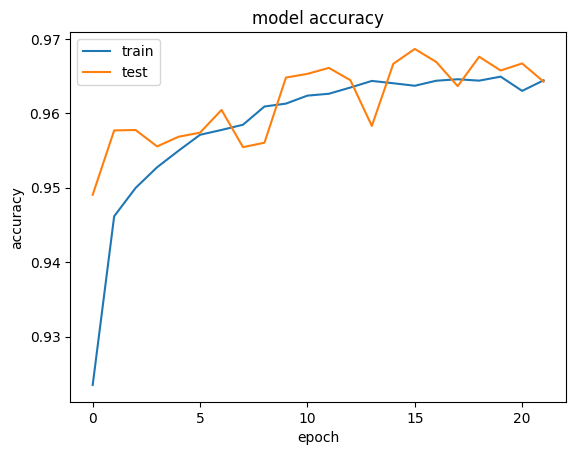

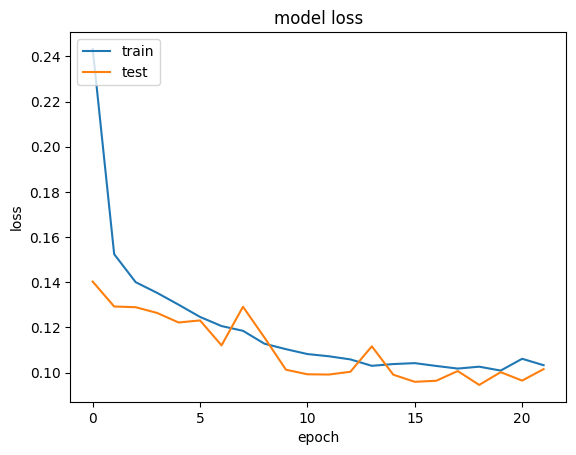

In [174]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [178]:
from sklearn.metrics import roc_curve

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

625/625 [==============================] - 1s 751us/step


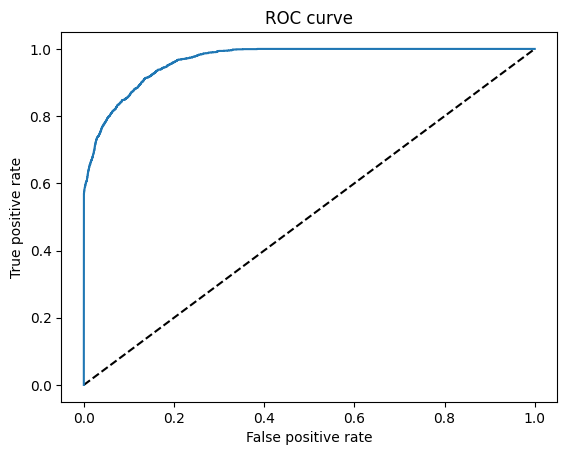

In [182]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()